In [48]:
import os
import numpy as np

## 핸드데이터 불러와서 정리하기
poker_hand_data = []
directory_path = 'HandData'

for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r') as file: # 파일을 읽어서 리스트에 추가
            file_contents = file.read()
            poker_hand_data.append(file_contents)

hand_data_list = []

for poker_hand in poker_hand_data: # 핸드데이터 한줄씩 2차원 리스트로 정리
    hand_data = [line.strip() for line in poker_hand.strip().split('\n\n')]

    hand_data_list = hand_data_list + hand_data

import pandas as pd
import re

hero_hands = [] # DataFrame을 저장할 리스트

rank_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
rank_mapping = {'A': 0, 'K': 1, 'Q': 2, 'J': 3, 'T': 4, '9': 5, '8': 6, '7': 7, '6': 8, '5': 9, '4': 10, '3': 11, '2': 12}

HoleCards_preflop = np.zeros((13,13), dtype=float)
HoleCards = np.zeros((13,13), dtype=float)

for hand_data in hand_data_list: # 각 포커 핸드 데이터에 대한 반복
    hand_date = hand_data.split('\n')[0]
    
    date_pattern = r"\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}" # 날짜를 추출하는 정규 표현식 패턴
    
    match = re.search(date_pattern, hand_date)

    FlopCard = []

    if match:
        extracted_date = match.group()
        
    for line in hand_data.split('\n'):
        if "Dealt to Hero" in line:
            hero_hand = line.split('[')[1].split(']')[0] # [Ad 5h]
        if "*** FLOP ***" in line:
            FlopCard = line.split('[')[1].split(']')[0] # [8h As 9d]

    hero_hands.append([extracted_date, hero_hand, FlopCard]) #날짜, 홀카드, 플랍

df = pd.DataFrame(hero_hands, columns=['Date', 'Hero Hand', 'FlopCard']) # DataFrame 생성
df['Date'] = pd.to_datetime(df['Date']) # 'Date' 열을 datetime 자료형으로 변환
df = df.sort_values(by='Date') # 날짜를 기준으로 DataFrame을 정렬
Total_preflop = len(df)
Total_preflop

34397

In [37]:
HoleCards_preidct = np.genfromtxt('CSVData/HoleCard.csv', delimiter=',')
distance = []

for index, row in df.iterrows():
    
    Date = row['Date']
    Hand = row['Hero Hand']

    hand = Hand.split() # ['Ad', '2s']

    hand_rank1, hand_rank2 = hand[0][0], hand[1][0] # ['A'] / ['2']
    hand_suit1, hand_suit2 = hand[0][1], hand[1][1] # ['d'] / ['s']

    # 홀카드 좌표 인식
    if hand_suit1 == hand_suit2:
        x = min(rank_mapping[hand_rank1], rank_mapping[hand_rank2])
        y = max(rank_mapping[hand_rank1], rank_mapping[hand_rank2])
    else:
        x = max(rank_mapping[hand_rank1], rank_mapping[hand_rank2])
        y = min(rank_mapping[hand_rank1], rank_mapping[hand_rank2])

    # 홀카드 기록
    HoleCards_preflop[x, y] += 1


print(HoleCards_preflop)
print(Total_preflop)
HoleCards_preflop /= Total_preflop

#유클리드 거리 분석
distance = np.linalg.norm(HoleCards_preflop - HoleCards_preidct)

print(HoleCards_preflop)
print(Total_preflop)
print(distance)

[[172.00500058 114.00331434 108.0031399   97.0028201   93.0027038
  101.00293639  96.00279102 103.00299453 101.00293639  99.00287824
   97.0028201  133.00386673 109.00316897]
 [311.00904175 159.00462263  98.00284917  97.0028201  109.00316897
   95.00276195  89.00258751  85.00247122 104.00302361  99.00287824
  114.00331434 104.00302361 109.00316897]
 [307.00892546 317.00921619 165.00479707  96.00279102  99.00287824
   96.00279102  95.00276195 103.00299453 101.00293639 101.00293639
   99.00287824 106.00308175  93.0027038 ]
 [332.00965229 332.00965229 311.00904175 165.00479707 118.00343063
  103.00299453 121.00351785  93.0027038  107.00311083  90.00261658
   96.00279102 102.00296546 114.00331434]
 [297.00863472 314.00912897 315.00915804 304.00883824 151.00439005
   91.00264566 106.00308175 101.00293639 122.00354692 116.00337249
   88.00255844 108.0031399   99.00287824]
 [282.00819863 322.00936155 291.00846029 324.0094197  310.00901268
  140.00407024  92.00267473  89.00258751 113.00328527 

In [51]:
import pandas as pd

# 홀카드 예측
HoleCards_preidct = np.genfromtxt('CSVData/HoleCard.csv', delimiter=',')
distance = []

# DataFrame을 100개씩 끊기 위한 코드
chunk_size = 1000
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

for chunk in chunks:
    HoleCards_preflop = np.zeros((13, 13), dtype=float)
    Total_preflop = len(chunk)
    
    for index, row in chunk.iterrows():
        Date = row['Date']
        Hand = row['Hero Hand']
        
        hand = Hand.split() # ['Ad', '2s']

        hand_rank1, hand_rank2 = hand[0][0], hand[1][0] # ['A'] / ['2']
        hand_suit1, hand_suit2 = hand[0][1], hand[1][1] # ['d'] / ['s']

        # 홀카드 좌표 인식
        if hand_suit1 == hand_suit2:
            x = min(rank_mapping[hand_rank1], rank_mapping[hand_rank2])
            y = max(rank_mapping[hand_rank1], rank_mapping[hand_rank2])
        else:
            x = max(rank_mapping[hand_rank1], rank_mapping[hand_rank2])
            y = min(rank_mapping[hand_rank1], rank_mapping[hand_rank2])

        # 홀카드 기록
        HoleCards_preflop[x, y] += 1
        
    HoleCards_preflop /= Total_preflop

    #유클리드 거리 분석
    distance.append(np.linalg.norm(HoleCards_preflop - HoleCards_preidct))
    
HoleCards_preflop
    


array([[0.00503778, 0.00503778, 0.00755668, 0.00503778, 0.00251889,
        0.        , 0.00251889, 0.        , 0.        , 0.00251889,
        0.        , 0.        , 0.00755668],
       [0.00755668, 0.        , 0.00755668, 0.        , 0.01259446,
        0.00251889, 0.00503778, 0.00251889, 0.00503778, 0.00251889,
        0.00503778, 0.00251889, 0.00251889],
       [0.01763224, 0.01259446, 0.00251889, 0.00503778, 0.00251889,
        0.00503778, 0.00251889, 0.        , 0.        , 0.00503778,
        0.00251889, 0.00251889, 0.00251889],
       [0.00503778, 0.00755668, 0.00755668, 0.00251889, 0.        ,
        0.        , 0.00251889, 0.00755668, 0.00251889, 0.00755668,
        0.00251889, 0.        , 0.        ],
       [0.00755668, 0.01763224, 0.01763224, 0.01763224, 0.00251889,
        0.00503778, 0.00503778, 0.        , 0.        , 0.00503778,
        0.00251889, 0.        , 0.        ],
       [0.00503778, 0.00755668, 0.01007557, 0.01763224, 0.00755668,
        0.        , 0.     

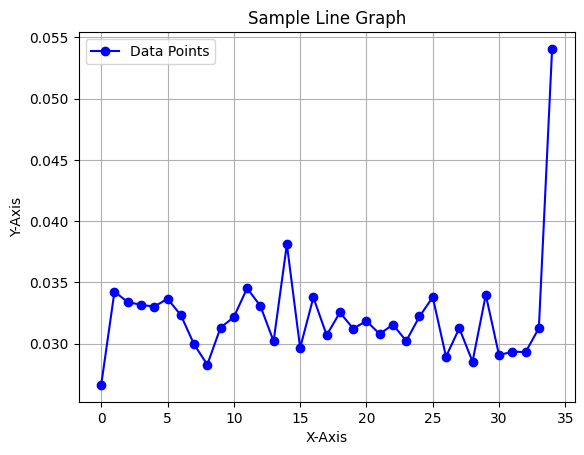

In [52]:
import matplotlib.pyplot as plt

x = distance

# 그래프 그리기
plt.plot(x, marker='o', linestyle='-', color='b', label='Data Points')

# 그래프에 제목과 라벨 추가
plt.title('Sample Line Graph')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')

# 그래프에 그리드 추가 (선택 사항)
plt.grid(True)

# 그래프에 범례 추가
plt.legend()

# 그래프 표시
plt.show()
